In [1]:

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.metrics import confusion_matrix, classification_report



In [2]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.6 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import re
import pandas as pd
from nltk.corpus import stopwords

# 1. Download once:
# import nltk
# nltk.download('stopwords')

EN_STOP = set(stopwords.words('english'))
FILLER = {
    "yeah","yea","uh","mhm","hmm","yo","woo","ooh","la","na","ah","aye",
    "mr","mrs","ms","dr"
}

def clean_text(text, min_len=3):
    t = str(text)

    # 2. Drop URLs, digits, and titles
    t = re.sub(r'https?://\S+|www\.\S+', ' ', t)
    t = re.sub(r'\w*\d\w*', ' ', t)
    t = re.sub(r'\b(Mr|Mrs|Ms|Dr)\.?\b', ' ', t, flags=re.IGNORECASE)

    # 3. Lowercase & keep only letters and spaces
    t = t.lower()
    t = re.sub(r'[^a-z\s]', ' ', t)

    # 4. Tokenize and filter
    tokens = t.split()
    tokens = [
        w for w in tokens
        if len(w) >= min_len
        and w not in EN_STOP
        and w not in FILLER
    ]

    return " ".join(tokens)

def build_clean_df(artist, min_len=3):
    df = pd.read_csv(f"{artist}.csv")
    cleaned = df['lyrics'].astype(str).apply(lambda s: clean_text(s, min_len))
    cleaned = cleaned[cleaned.str.split().str.len() >= 1]  # drop empty ones
    out = pd.DataFrame({
        'clean_lyric': cleaned,
        'artist': artist
    }).drop_duplicates('clean_lyric').reset_index(drop=True)
    return out

# Example usage for multiple artists:
artists = ["TaylorSwift","Beyonce","Rihanna","ArianaGrande"]
dfs = [build_clean_df(a) for a in artists]
all_df = pd.concat(dfs, ignore_index=True)


In [5]:

all_df.sample(5)

,clean_lyric,artist
23,said simple way second day strange know stumbl...,TaylorSwift
298,breakin settin real way makin girls dem chill ...,Rihanna
320,type get heart broken type get upset cry cause...,Rihanna
396,woah say midnight shadows finding love battle ...,ArianaGrande
386,whiskey got feelin pretty pardon impolite real...,Rihanna


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

all_df["artist"].value_counts()





artist
TaylorSwift     182
Rihanna         112
ArianaGrande    100
Beyonce          97
Name: count, dtype: int64

In [14]:
for artist in all_df['artist'].unique():
    sub = all_df[all_df['artist']==artist]
    dfs.append(resample(sub, replace=True, n_samples=97, random_state=0))
balanced_df = pd.concat(dfs)
balanced_df.head()


,clean_lyric,artist,artist_id
0,knew killer first time saw wondered many girls...,TaylorSwift,NaN
1,feels like perfect night dress like hipsters m...,TaylorSwift,NaN
2,would wanna break perfectly good heart would w...,TaylorSwift,NaN
3,know want ask cause still trying figure know r...,TaylorSwift,NaN
4,blew things proportion blue put jail something...,TaylorSwift,NaN


In [78]:
from sklearn.pipeline import make_pipeline
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=2,
    max_df=0.95,
    max_features=10000,
    ngram_range=(1, 2)
)
le = LabelEncoder()
balanced_df['encoded_label'] = le.fit_transform(balanced_df['artist'])
class_names = le.classes_
features = tfidf.fit_transform(balanced_df.clean_lyric).toarray()
feature_names = np.array(tfidf.get_feature_names_out())
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))
N = 3
for artist_id, artist in enumerate(class_names):
  y_bin = (balanced_df['encoded_label'] == artist_id).astype(int)

  # calc chi2 scores
  chi2_scores, p_vals = chi2(features, y_bin)

  sorted_idx = np.argsort(chi2_scores)

  unigrams_idx = [i for i in sorted_idx if len(feature_names[i].split()) == 1]
  bigrams_idx  = [i for i in sorted_idx if len(feature_names[i].split()) == 2]

  top_unigrams = feature_names[unigrams_idx[-N:]]
  top_bigrams  = feature_names[bigrams_idx[-N:]]

  print(f"\n=== Top {N} for {artist} ===")
  print("Unigrams:", ", ".join(top_unigrams))
  print("Bigrams: ", ", ".join(top_bigrams))


Each of the 1655 complaints is represented by 10000 features (TF-IDF score of unigrams and bigrams)

=== Top 3 for ArianaGrande ===
Unigrams: possessin, shit, ayy
Bigrams:  like supernatural, santa tell, care anymore

=== Top 3 for Beyonce ===
Unigrams: satellites, forward, beyonc
Bigrams:  let let, turn lights, forward forward

=== Top 3 for Rihanna ===
Unigrams: rihanna, pon, gyal
Bigrams:  come turn, wait wait, way lie

=== Top 3 for TaylorSwift ===
Unigrams: dancing, darling, honey
Bigrams:  coming undone, back together, new york


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns

X,y=balanced_df['clean_lyric'],balanced_df['encoded_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
tfidf.fit(X_train)

X_train_vec = tfidf.transform(X_train)
X_test_vec = tfidf.transform(X_test)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM":                SVC(kernel='linear', probability=True, class_weight='balanced'),
    "RandomForest":       RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "MultinomialNB":      MultinomialNB()
}

In [105]:



cleaner = FunctionTransformer(lambda texts: [clean_text(t) for t in texts], validate=False)
pipelines = {}
for name, clf in models.items():
    pipelines[name] = Pipeline([
        ("clean", cleaner),
        ("tfidf", tfidf),
        ("clf",   clf),
    ])

#cross-val eval
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1) #use f1_macro instead of accuracy because classes imbalanced
    print(f"{name:16s} CV F1‑macro: {scores.mean():.3f} ± {scores.std():.3f}")

#fit on train split & print hold‑out
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n== {name} on Hold‑Out ==")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))


LogisticRegression CV F1‑macro: 0.945 ± 0.014
SVM              CV F1‑macro: 0.938 ± 0.014
RandomForest     CV F1‑macro: 0.932 ± 0.028
MultinomialNB    CV F1‑macro: 0.912 ± 0.030

== LogisticRegression on Hold‑Out ==
Accuracy: 0.9577039274924471
              precision    recall  f1-score   support

ArianaGrande       0.97      0.99      0.98        78
     Beyonce       0.93      0.96      0.94        77
     Rihanna       0.97      0.90      0.94        81
 TaylorSwift       0.96      0.98      0.97        95

    accuracy                           0.96       331
   macro avg       0.96      0.96      0.96       331
weighted avg       0.96      0.96      0.96       331


== SVM on Hold‑Out ==
Accuracy: 0.9607250755287009
              precision    recall  f1-score   support

ArianaGrande       0.97      0.99      0.98        78
     Beyonce       0.95      0.96      0.95        77
     Rihanna       0.96      0.91      0.94        81
 TaylorSwift       0.96      0.98      0.97        


== LogisticRegression Confusion Matrix ==


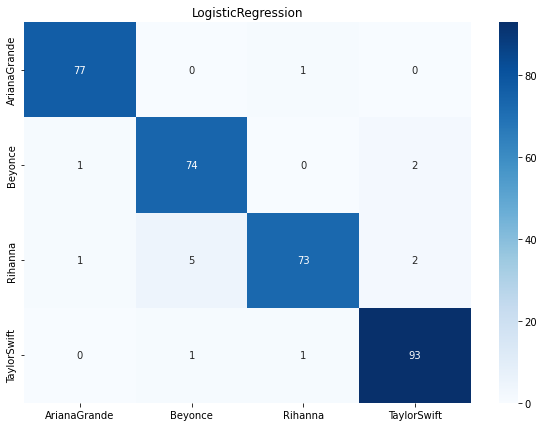


== SVM Confusion Matrix ==


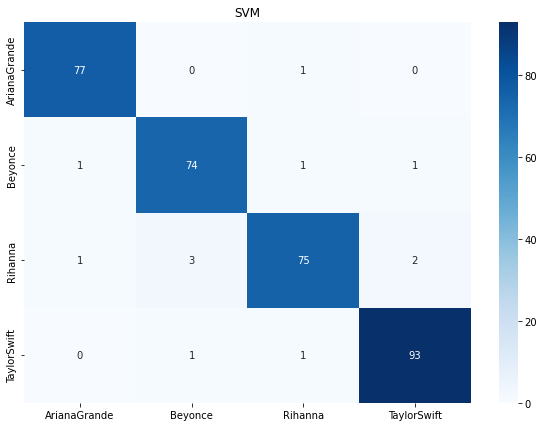


== RandomForest Confusion Matrix ==


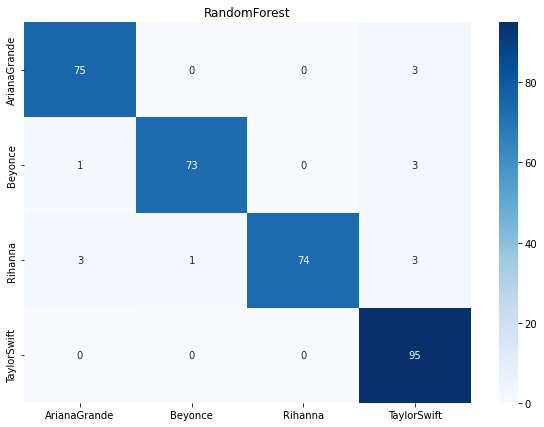


== MultinomialNB Confusion Matrix ==


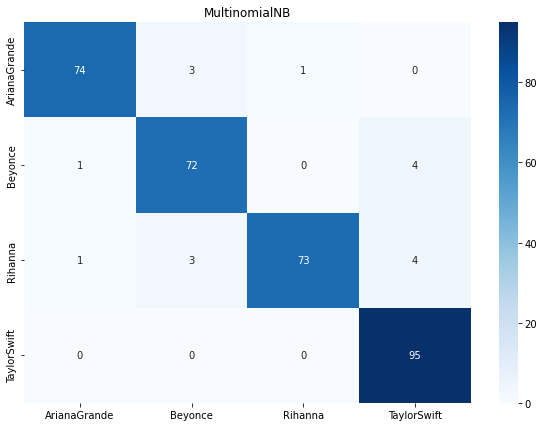


== ROC Comparison Curve ==


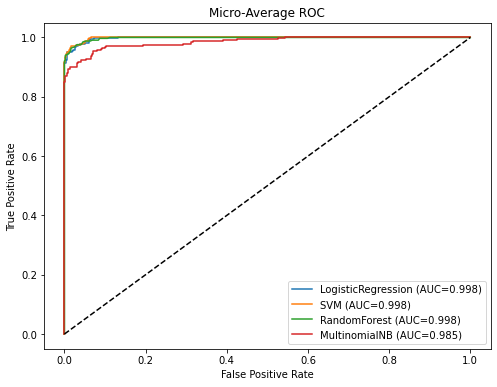

In [108]:
y_train_bin = label_binarize(y_train, classes=range(len(class_names)))
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
# Create shared ROC plot
fitted = {}
for name, base in models.items():
    clf = OneVsRestClassifier(base)
    clf.fit(X_train_vec, y_train_bin)
    fitted[name] = clf

# 6) Confusion matrix (uses y_te and the argmax of predicted probs)
for name, clf in fitted.items():
    # predict class indices
    y_score = clf.predict_proba(X_test_vec)
    y_pred  = np.argmax(y_score, axis=1)

    plt.figure(figsize=(10, 7))
    print(f"\n== {name} Confusion Matrix ==")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
    plt.title(name); plt.show()
plt.figure(figsize=(8,6))

print(f"\n== ROC Comparison Curve ==")
for name, clf in fitted.items():
    y_score = clf.predict_proba(X_test_vec)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro‑Average ROC")
plt.legend(loc="lower right")
plt.show()


In [86]:
pipe=pipelines["SVM"]

In [94]:
new_lyrics = ["""Want is the cigarette smoke on a jacket
You wore to the wrong part of town
Desire is the sound of the whiskey
Telling me you miss me, can you come around?
Passion is a passing thing, it's
Accidental chemistry (Ah-ah-ah-ah)
Lust is a liar, a short-lived fire
It ain't what you and I are at all
Oh, it's a need, it's a need
I would go anywhere that you lead
I am hopeless, breathless, burning slow
Touch me, hold me, tell me, "I won't let you go"
I won't leave, it's a need
Danger is a thousand prickles on my neck
That tell me to run or to freeze
Fear is the nightmare I had, you were with someone else
You forgot about me
Passion is a passing thing, it's
Accidental chemistry (Ah-ah-ah-ah)
Caught up in a feelin', it can be deceivin'
This is like breathing for me (Ah)
Oh, it's a need, it's a need
I would go anywhere that you lead
I am hopeless, breathless, burning slow
Touch me, hold me, tell me, "I won't let you go"
I won't leave, it's a need
Baby, it's always a new kiss every time we do this, the truth is (Ah-ah-ah-ah)
It's essential to me that you love me more than wishing, longing
Oh, it's a need (It's a need), it's a need (Ah-ah, ah-ah)
I would go (I would go) anywhere (Anywhere) that you lead (Oh, oh)
I am hopeless, breathless, burning slow (Burning slow)
Touch me, hold me, tell me, "I won't let you go"
I won't leave (I won't leave), it's a need (Oh)""","""Baby, you're the only man that I want
And baby, you're the only man that I love""","""I rest my hand across your lips
Feel your breath by my fingertips
No longer can I alay what is right
But this love, it won't give up without a fight""","""i didn't think you'd leave my life, i bet that day you know didn't even think about it"""]
for lyric in new_lyrics:
    artist_id = pipe.predict([lyric])[0]
    artist    = le.inverse_transform([artist_id])[0]
    print("Predicted artist:", artist)

Predicted artist: TaylorSwift
Predicted artist: Beyonce
Predicted artist: Rihanna
Predicted artist: ArianaGrande
